[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IBM/ICX360/blob/main/examples/cell/quick_start.ipynb)

## CELL Quick Start

This notebook shows a simple example of using `CELL` to get users started. For more complete examples, please see the notebooks on natural language generation.

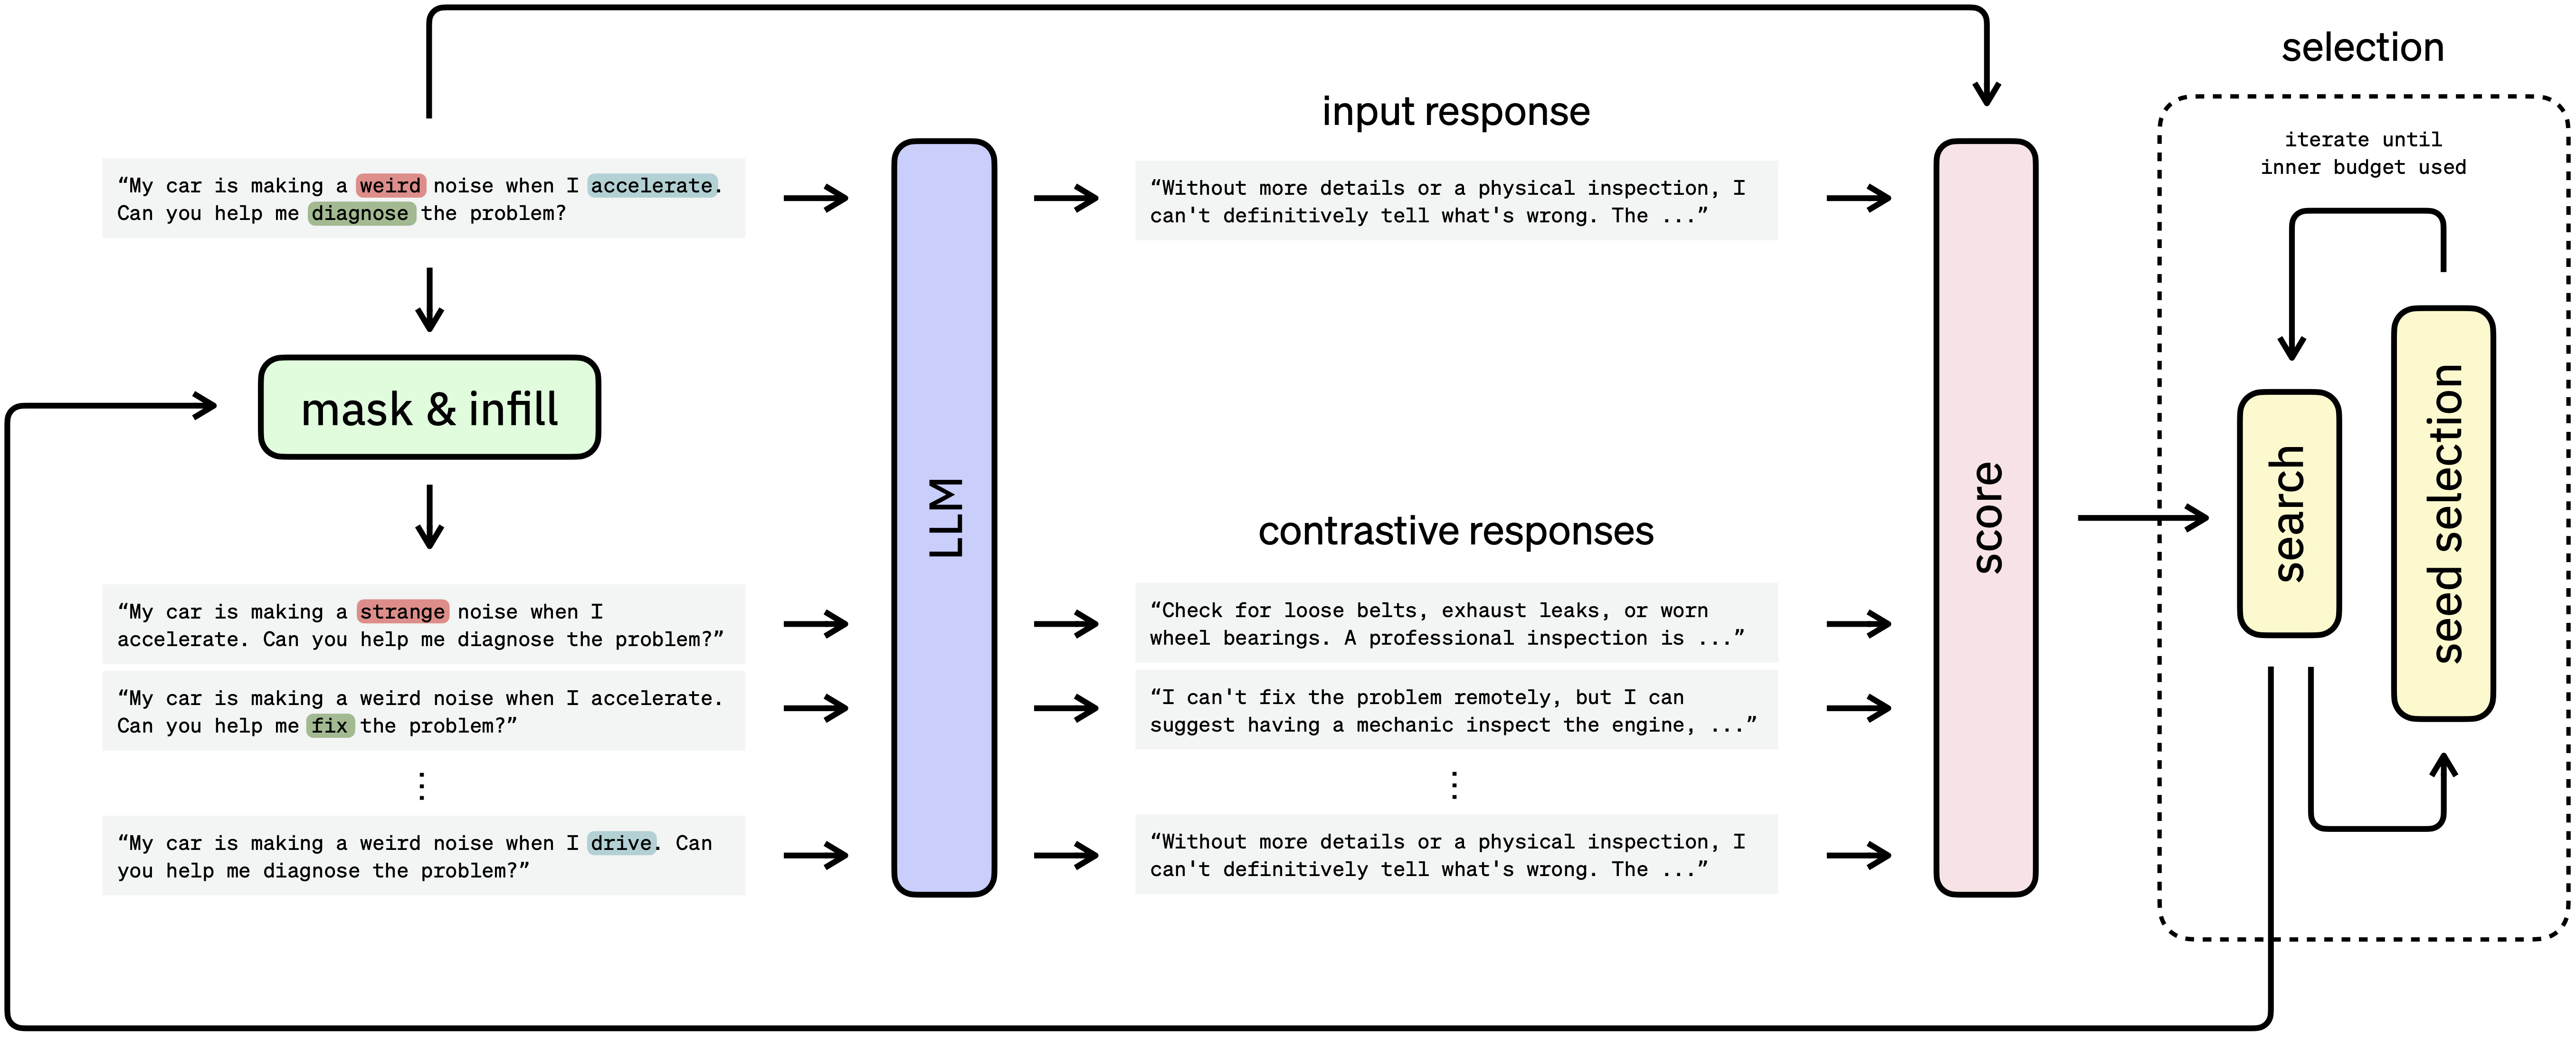

The above figure illustrates the `CELL` algorithm. The input prompt is "My car is making a weird noise when I accelerate. Can you help me diagnose the problem?". The **mask & infill** block generates potential contrastive prompts. The input prompt and generated contrastive prompts are passed through the **LLM** to obtain input and contrastive responses for the corresponding prompts. The **score** block produces scores for the input prompt relative to the input and contrastive responses. The **selection** block performs the intelligent search among these potential explanations and then sends the best explanation found so far back to the **mask & infill** block to continue the search for an explanation if necessary. 

### Install ICX360 for Colab - skip if you have ICX360 installed
**Note for Google Colab:** Switch to a GPU runtime for faster execution.

In [ ]:
# Clone the repository after removing the old copy if any
!rm -rf ICX360
!git clone https://github.com/IBM/ICX360.git

# Install the package
%cd ICX360
!pip install uv
!uv pip install .
%cd ..

### Import Standard Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import torch
import random
from transformers import T5Tokenizer, T5ForConditionalGeneration

### Import icx classes

In [2]:
from icx360.algorithms.cell.CELL import CELL # this imports a budgeted version of CELL
from icx360.utils.model_wrappers import HFModel
from icx360.utils.general_utils import select_device, fix_seed 

In [3]:
# Fix seed for experimentation
seed = 12345
fix_seed(seed)

### Load model, use icx wrapper class, and create explainer object

In [ ]:
# Note device is set automatically according to your system. You can overwite device here if you choose.
device = select_device()
model_name = "google/flan-t5-large"
model = T5ForConditionalGeneration.from_pretrained(model_name, device_map=device)
tokenizer = T5Tokenizer.from_pretrained(model_name)

model_expl = HFModel(model, tokenizer) # icx wrapped model
num_return_sequences = 10 # number of sequences returned when doing generation for mask infilling
infiller = 't5' # function used to input text with a mask token and output text with mask replaced by text ('t5' and 'bart')
scalarizer = 'nli' # scalarizer to use to determine if a contrast is found (must be from ['preference', 'nli', 'contradiction', 'bleu']
# if no device is passed to CELL, it will be set automatically according to your system
explainer = CELL(model_expl, num_return_sequences=num_return_sequences, infiller=infiller, scalarizer=scalarizer, device=device) 

### Fix parameters for budgeted CELL explanations

In [5]:
split_k = 2 
epsilon_contrastive = 0.5
radius = 3 # radius for sampling near a previously modified token 
budget = 50 # maximum number of queries allowed from infilling model

### Feed an input prompt to the explainer and generate contrastive explanation

In [6]:
input_text = "What is the best way to get from New York to Los Angeles?"
result = explainer.explain_instance(input_text, radius=radius, budget=budget, split_k=split_k, epsilon_contrastive=epsilon_contrastive)

Starting Contrastive Explanations for Large Language Models
Running outer iteration 1
Stopping because contrastive threshold has been passed
10 model calls made.
Contrastive Explanation Solution
Scalarizer: nli
Input prompt: What is the best way to get from New York to Los Angeles?
Input response: Airline
Contrastive prompt: What is the best price to get from New York to Los Angeles?
Contrastive response: $1,099
Modifications made: 
        to Los->to Los
        way to->price to
NLI initial prediction: neutral
NLI modified prediction: contradiction


**Input prompt** is the user prompt for which one wants to explain the response of the LLM.<br>
**Input response** is the response of the LLM to the input prompt.<br>
**Contrastive prompt** is the new prompt after masking and infilling certain words.<br>
**Contrastive response** is the response of the LLM to the contrastive prompt.
<br><br>
The above example shows that if a user makes the described modifications to the input prompt, the new contrastive response would contradict the original response of input prompt.

### Quick start using myopic CELL (mCELL)

Another option for short prompts is to use the myopic `CELL` algorithm as follow below.

In [7]:
from icx360.algorithms.cell.mCELL import mCELL # this imports a myopic version of CELL
# if no device is passed to mCELL, it will be set automatically according to your system
explainer = mCELL(model_expl, num_return_sequences=num_return_sequences, infiller=infiller, scalarizer=scalarizer, device=device)

fix_seed(seed)
result = explainer.explain_instance(input_text, split_k=split_k, epsilon_contrastive=epsilon_contrastive)

Starting (myopic) Contrastive Explanations for Large Language Models
Running iteration 1
Stopping because contrastive threshold has been passed
7 model calls made.
Contrastive Explanation Solution
Scalarizer: nli
Input prompt: What is the best way to get from New York to Los Angeles?
Input response: Airline
Contrastive prompt: What is the best price to get from New York to Los Angeles?
Contrastive response: $1,099
Modifications made: 
        way to->price to
NLI initial prediction: neutral
NLI modified prediction: contradiction


The explanation is of the same type as for `CELL`, although the exact output of the explanation can differ due to the different search algorithm used to find an explanation.